In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F




In [4]:
#initialize gym environment
env = gym.make('combrf-v0')

In [5]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [6]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)

Size of each action:  (1,)
Size of each observation:  (130,)
Observation looks like:
[-2.41468176e-07 -5.69246307e-08  3.10426658e-07 -3.19126140e-07
  7.61626635e-08  2.26862710e-07 -3.50984090e-07  1.98319323e-07
 -5.69246307e-08  3.10426658e-07 -3.19126140e-07  7.61626635e-08
  2.26862710e-07 -3.50984090e-07  1.98319323e-07  1.10740114e-07
  3.10426658e-07 -3.19126140e-07  7.61626635e-08  2.26862710e-07
 -3.50984090e-07  1.98319323e-07  1.10740114e-07 -3.32469869e-07
 -3.19126140e-07  7.61626635e-08  2.26862710e-07 -3.50984090e-07
  1.98319323e-07  1.10740114e-07 -3.32469869e-07  2.92013796e-07
  7.61626635e-08  2.26862710e-07 -3.50984090e-07  1.98319323e-07
  1.10740114e-07 -3.32469869e-07  2.92013796e-07 -2.12755663e-08
  2.26862710e-07 -3.50984090e-07  1.98319323e-07  1.10740114e-07
 -3.32469869e-07  2.92013796e-07 -2.12755663e-08 -2.66240581e-07
 -3.50984090e-07  1.98319323e-07  1.10740114e-07 -3.32469869e-07
  2.92013796e-07 -2.12755663e-08 -2.66240581e-07  3.43799335e-07
  1.9

## Perform random actions in the environment

In [7]:
obs = env.reset()
count = 0
ep_rwd=0
rewards =[]
actions =[]
while True:
    action = np.array([round(np.random.uniform(0,2*math.pi), 2)])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    rewards.append(rwd)
    actions.append(action)
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))
print(rewards)
print(actions)

Random TX location: [[300 250   0]]
Capacity: 4.5921960668329417e-08
Episodic score: 1.5 with episode length: 8 
[0.3, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3]
[array([4.88]), array([5.11]), array([6.05]), array([5.62]), array([5.95]), array([0.54]), array([2.93]), array([0.25])]


## Instantiate DDPG agent

In [8]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[0]
action_size = env.action_space.shape[0]
print(action_size)
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

1
<class 'numpy.ndarray'>
tensor([-2.1451e-07,  1.6627e-07,  2.6941e-07, -7.7324e-08, -2.9494e-07,
        -2.0049e-08,  2.8832e-07,  1.1524e-07,  1.6627e-07,  2.6941e-07,
        -7.7324e-08, -2.9494e-07, -2.0049e-08,  2.8832e-07,  1.1524e-07,
        -2.5027e-07,  2.6941e-07, -7.7324e-08, -2.9494e-07, -2.0049e-08,
         2.8832e-07,  1.1524e-07, -2.5027e-07, -1.9786e-07, -7.7324e-08,
        -2.9494e-07, -2.0049e-08,  2.8832e-07,  1.1524e-07, -2.5027e-07,
        -1.9786e-07,  1.8495e-07, -2.9494e-07, -2.0049e-08,  2.8832e-07,
         1.1524e-07, -2.5027e-07, -1.9786e-07,  1.8495e-07,  2.5892e-07,
        -2.0049e-08,  2.8832e-07,  1.1524e-07, -2.5027e-07, -1.9786e-07,
         1.8495e-07,  2.5892e-07, -9.9464e-08,  2.8832e-07,  1.1524e-07,
        -2.5027e-07, -1.9786e-07,  1.8495e-07,  2.5892e-07, -9.9464e-08,
        -2.9176e-07,  1.1524e-07, -2.5027e-07, -1.9786e-07,  1.8495e-07,
         2.5892e-07, -9.9464e-08, -2.9176e-07,  3.1397e-09, -2.0448e-07,
        -2.4533e-07,  1.2

In [9]:
agent.reset()

In [10]:
obs = env.reset()

print(env.action_space.sample())
action = agent.act(obs)
print(action)

[5.42061]
[3.311892]


## DDPG Training

Episode 100	Average Score: 0.26
Episode actions: [array([6.2831855], dtype=float32)]
Episode 200	Average Score: 0.95
Episode actions: [array([0.15409604], dtype=float32), array([0.7302734], dtype=float32), array([2.1670904], dtype=float32), array([2.9402528], dtype=float32), array([3.067545], dtype=float32), array([2.8895082], dtype=float32), array([2.7569952], dtype=float32), array([4.1569533], dtype=float32)]
Episode 300	Average Score: 1.23
Episode actions: [array([0.73613846], dtype=float32), array([1.3423971], dtype=float32), array([1.686867], dtype=float32), array([2.7394114], dtype=float32), array([3.882214], dtype=float32), array([5.1414948], dtype=float32), array([5.635975], dtype=float32), array([4.7929993], dtype=float32)]
Episode 400	Average Score: 1.19
Episode actions: [array([0.68042505], dtype=float32), array([0.83355755], dtype=float32), array([1.4234468], dtype=float32), array([2.1318874], dtype=float32), array([3.1146255], dtype=float32), array([4.2299585], dtype=float

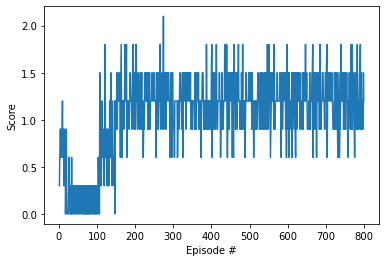

In [11]:
train_episodes = 800
print_every= 100

scores_deque = deque(maxlen=print_every)
scores = []

for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    ep_rwds = []
    ep_actions =[]
    score = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        ep_rwds.append(reward)
        ep_actions.append(action)
        if done:
            break
            
    scores_deque.append(score)
    scores.append(score)
    #print('\rEpisode {}\t, TX loc: {}\t, Score: {:.2f}\n'.format(i_episode, env.tx_loc, score), end="")
    
    #print(ep_rwds)
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        print("Episode actions: {}".format(ep_actions))
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

## Testing the DDPG agent

env rssi value:(1.750187284918997e-06-7.430253840053699e-07j)
TX loc: [[200   0   0]], episode score: 0.3

TX_beam dir: [ 0.35355339+0.00000000e+00j -0.35355339-4.32978028e-17j
  0.35355339+8.65956056e-17j -0.35355339-1.29893408e-16j
  0.35355339+1.73191211e-16j -0.35355339-2.16489014e-16j
  0.35355339+2.59786817e-16j -0.35355339-3.03084620e-16j]
eps rwds: [0.3]

Applied RX directions: [array([6.842237e-07], dtype=float32)]
9.42477796076938
6.842237e-07


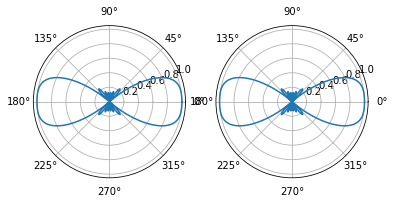

In [28]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

score = 0.0
eps_rwd =[]
obs = env.reset()
agent.reset()
agent.actor_local.eval()
agent.critic_local.eval()
ep_actions =[]
while True:
    #obs_tensor = torch.from_numpy(obs).float().to(device)
    
    #with torch.no_grad():
    #    action =agent.actor_local(obs_tensor).cpu().data.numpy()
        #print("old_action: {}", action)
    #    best_action = agent.critic_local(obs_tensor)

    action =  agent.act(obs,add_noise=False)#.cpu().data.numpy()
    #action == np.clip(action, 0, 2*np.pi)
    
    #action_tensor = agent.actor_local(obs_tensor).to(device)
    #print(obs, action)
    #q_val = agent.critic_local(obs_tensor, action_tensor).cpu().data.numpy()
    obs, rwd, done, _ = env.step(action)
    print("env rssi value:{}".format(env.rssi_val))
    ep_actions.append(action)
    score +=rwd
    eps_rwd.append(rwd)
    if done:
        break
print("TX loc: {0}, episode score: {1}\n".format(env.tx_loc, score))
print("TX_beam dir: {}".format(env.tx_beam))
print("eps rwds: {}\n".format(eps_rwd))
print("Applied RX directions: {}".format(ep_actions))

from Source.misc_fun.utils import plotbeam
print(env.channel.az_aod[0])
print(ep_actions[-1][0])
tx_theta, tx_gr = plotbeam(env.channel.az_aod[0], env.N_tx)
rx_theta, rx_gr = plotbeam(ep_actions[-1][0], env.N_rx)
ax1 = plt.subplot(121, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(122, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()
